# Category classification for morphological galaxy classification #2.1 (ResNet18)
---
**Author:** Jorge Barrio Conde

**Tfms:** `[Normalize.from_stats(mean=0.0, std=1.0), Rotate(p=1.0, draw=random_rotation), GaussianNoise()]`

**Images size**: 200x200 pixels

**Neural Network:** ResNet18

**Training method:** `fine_tune()`

**Epochs:** 20

**Learning rate:** default

Paper: *A catalog of visual-like mophologies in the 5 CANDELS fields using Deep-Learning* (M. Huertas-Company, 2015)

## 0. Install fastai and fastbook (Google Colab)

In [ ]:
!pip install -Uqq fastbook
import fastbook
fastbook.setup_book()

## 1. Setup

### Imports

In [1]:
import fastai
from fastai.vision.all import *
from fastbook import *

fastai.__version__

'2.3.0'

### Paths

In [ ]:
# Specify project path
project_root_path = "/content/gdrive/MyDrive/galaxy_morphological_classification/"

In [2]:
dataset_path = project_root_path + "datasets/rgb_200x200/"
csv_results_path = project_root_path + "src/classification/results/2.1-TFMS-ResNet18-fine_tune-20_epochs.csv"

## 2. My functions

### 2.1. Tfms

In [3]:
def random_rotation(x):
    '''
    Return a float tensor equal in size to batch with random
    rotations multiples of 90. 
    
    x: full batch tensor
    '''
    size = x.size(0)
    result = torch.zeros(([size]), dtype=float, device='cuda')
    
    for i in range(size):
        degree = torch.rand(1)
        if (degree < 0.25):
            result[i] = 0.0
        elif (degree < 0.5):
            result[i] = 90.0
        elif (degree < 0.75):
            result[i] = 180.0
        else:
            result[i] = 270.0
    
    return result

In [4]:
class GaussianNoise(Transform):
    order = 100 #after normalize
    
    def encodes(self, x:TensorImage):
        noise = torch.normal(
            mean=0.0, 
            std=0.005,
            size=x.shape,
            device='cuda'
        )
        return x + noise

### 2.2. Others

In [5]:
def datasets_info(dls):
    for ds_i, ds in enumerate([dls.train_ds, dls.valid_ds]):
        
        ds_name = "TRAIN" if ds_i == 0 else "VALID"
        print(f"Dataset: {ds_name}")
        print(ds)

        categories = [0,0,0,0,0,0]

        for data in ds:
            categories[data[1]] += 1

        for i, cat in enumerate(categories):
            print(f" - {dls.vocab[i]}:  \t{cat} ({(cat/len(ds))*100:.1f}%)")
        
        print("")

## 3. Experiment:

### 3.1. DataBlock and DataLoaders

In [6]:
tfms = [Normalize.from_stats(mean=0.0, std=1.0), Rotate(p=1.0, draw=random_rotation), GaussianNoise()]

blocks = DataBlock(
    blocks = (ImageBlock, CategoryBlock), 
    get_items = get_image_files, 
    splitter = RandomSplitter(valid_pct=0.2, seed=42),
    get_y = Pipeline([
        attrgetter("name"), 
        RegexLabeller(pat = r'^(.*)_\d+_.*.png')
    ]),
    batch_tfms = tfms
)

dls = blocks.dataloaders(source=dataset_path)

### 3.2. Show details

In [7]:
dls.loss_func

FlattenedLoss of CrossEntropyLoss()

In [ ]:
datasets_info(dls)

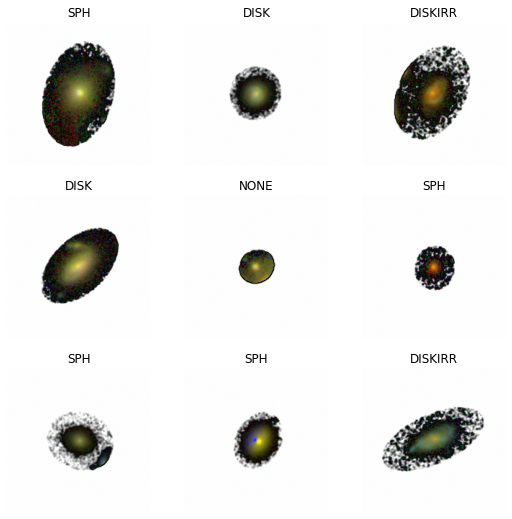

In [9]:
dls.show_batch()

### 3.3. Learner and Training

Downloading: "https://download.pytorch.org/models/resnet18-5c106cde.pth" to /root/.cache/torch/hub/checkpoints/resnet18-5c106cde.pth


epoch,train_loss,valid_loss,accuracy,time
0,2.280656,1.586068,0.497110,00:12


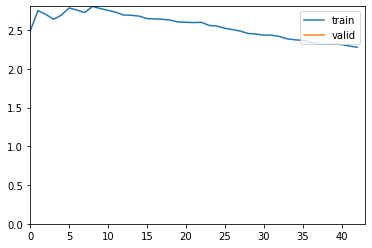

epoch,train_loss,valid_loss,accuracy,time
0,1.746763,1.424716,0.530347,00:14
1,1.612824,1.365312,0.540462,00:14
2,1.492262,1.339621,0.537572,00:14
3,1.396817,1.357344,0.560694,00:14
4,1.294904,1.291166,0.553468,00:14
5,1.207969,1.307906,0.579480,00:14
6,1.117890,1.265324,0.544798,00:14
7,1.050522,1.204322,0.563584,00:14
8,0.975462,1.258467,0.582370,00:14
9,0.907933,1.208373,0.589595,00:14


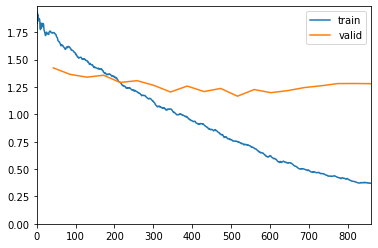

In [10]:
learn = cnn_learner(
    dls, resnet18, 
    metrics=accuracy, 
    cbs = [
        ShowGraphCallback(),
        CSVLogger(fname=csv_results_path, append=true)
    ]
)

learn.fine_tune(epochs=20)

### 3.4. Results

In [ ]:
interp=ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix()

In [ ]:
interp.most_confused(min_val=20)

In [ ]:
interp.plot_top_losses(10, nrows=2)